<a href="https://colab.research.google.com/github/saimani5/VAE-tutorials/blob/main/rvae_cards.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   This notebook takes you through the application of rotationally invariant variational autoencoder (rVAE) on four different cards datasets and the results analysis.  
*   Each cards dataset if formed by applying a random rotation and shear to the images of the cards. The datasets differ in the limits used for picking the rotations and shear.
*   rVAE comprises of an additional latent dimension to the regular VAE, which explicitly captures the rotations involved in the image.
*   This angular latent dimension is unsupervisedly learned while trying to reconstuct the original image.
*   Like in VAE, this latent dimension is also regularized using a prior.  

The rVAEs are defined and trained using a package called Pyroved (https://github.com/ziatdinovmax/pyroVED) which is built on top of Pyro probabilistic programming framework. Please feel free to write to valletisai.mani@gmail.com for further enquiries.

In [ ]:
# Installing Kornia and pyroved
!pip install -q kornia git+https://github.com/ziatdinovmax/pyroVED@main

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.0/612.0 KB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 KB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 32.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.10.1 requires matplotlib>=3.5.0, but you have matplotlib 3.3.4 which is incompatible.
mizani 0.8.1 requires matplotlib>=3.5.0, but you have matplotlib 3.3.4 which is incompatible.


In [ ]:
# Importing necessary packages

import pyroved as pv
import kornia as K


import cv2
from torchvision.utils import make_grid
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 3

tt = torch.tensor

In [ ]:
#@title Helper functions that apply afffine transformations to the dataset
rs = lambda x: cv2.resize(x, (64, 64), cv2.INTER_CUBIC)

def get_data():
    card1 = rs(cv2.imread("cards/card1.JPG", cv2.IMREAD_GRAYSCALE))
    card2 = rs(cv2.imread("cards/card2.JPG", cv2.IMREAD_GRAYSCALE))
    card3 = rs(cv2.imread("cards/card3.JPG", cv2.IMREAD_GRAYSCALE))
    card4 = rs(cv2.imread("cards/card4.JPG", cv2.IMREAD_GRAYSCALE))
    card1 = tt(1 - card1 / card1.max())
    card2 = tt(1 - card2 / card2.max())
    card3 = tt(1 - card3 / card3.max())
    card4 = tt(1 - card4 / card4.max())
    return card1, card2, card3, card4


import math
def transform_imgs(cards, **kwargs):
    np.random.seed(0)
    torch.manual_seed(0)

    a = kwargs.get("angle")
    t = kwargs.get("translation")
    s = (kwargs.get("shear"))
    if s is not None:
        s = math.radians(s)
    

    n_samples = kwargs.get("samples", 3000)
    n_samples_total = n_samples*4
    
    card1, card2, card3, card4 = cards[0], cards[1], cards[2], cards[3]

    card1 = card1[None, None].repeat_interleave(n_samples, dim = 0)
    card2 = card2[None, None].repeat_interleave(n_samples, dim = 0)
    card3 = card3[None, None].repeat_interleave(n_samples, dim = 0)
    card4 = card4[None, None].repeat_interleave(n_samples, dim = 0)

    cards_all = torch.cat((card1, card2, card3, card4), dim = 0)

    angles = tt(np.random.uniform(low = -a, high = a, size = [n_samples_total]))
    translations = tt(np.random.uniform(low = -t, high = t, size = [n_samples_total,1])).repeat_interleave(2, dim = 1)
    shears = tt(np.random.uniform(low = -s, high = s, size = [n_samples_total, 1])).repeat_interleave(2, dim = 1)

    transform = nn.Sequential(
        K.augmentation.CenterCrop((48, 48)),
        K.geometry.Affine(angle = angles, translation = translations,
                          shear = shears)
    )

    cards = transform(cards_all).squeeze().float() 
    labels = torch.cat([torch.zeros(len(card1)), torch.ones(len(card2)),
                           2*torch.ones(len(card3)), 3*torch.ones(len(card4))])
    return cards, labels, angles, translations, shears


def plot_manifolds(model):   
    fig, axes = plt.subplots(2, 2, figsize=(12, 12),
                            subplot_kw={'xticks':[], 'yticks':[]},
                            gridspec_kw=dict(hspace=0.1, wspace=0.05))
    for i, ax in enumerate(axes.flat):
        manifold = model.manifold2d(d=9, label=i, plot=False)
        grid = make_grid(manifold[:, None], nrow=9, pad_value=.5)
        ax.imshow(grid[0], cmap='viridis')
    plt.show()

In [ ]:
# Downloading the cards dataset
!gdown -q https://drive.google.com/uc?id=1AyGHVflbIjzinkKBURHNVDx1wWg9JixB
!unzip -o -qq cards.zip

Here we make 4 different datasets using the above helper functions which are as follows:  
*  cards-i: low rotations (12 degrees) and low shear (1 degree)
*  cards-ii: low rotations (12 degrees) and high shear (20 degrees)
*  cards-iii: high rotations (120 degrees) and low shear (1 degree)
*  cards-iv: high rotations (120 degrees) and high shear (20 degrees)

In [ ]:
# And the ground truth values of the transformations applied to analyze the latent spaces. 
cards = get_data()
cards_all1, labels_all1, angles_all1, translations_all1, shears_all1 = transform_imgs(cards, angle = 12, translation = 0.1, shear = 1, samples = 3000)   # cards-i
cards_all2, labels_all2, angles_all2, translations_all2, shears_all2 = transform_imgs(cards, angle = 12, translation = 0.1, shear = 20, samples = 3000)   # cards-ii
cards_all3, labels_all3, angles_all3, translations_all3, shears_all3 = transform_imgs(cards, angle = 120, translation = 0.1, shear = 1, samples = 3000)   # cards-iii
cards_all4, labels_all4, angles_all4, translations_all4, shears_all4 = transform_imgs(cards, angle = 120, translation = 0.1, shear = 20, samples = 3000)   # cards-iv

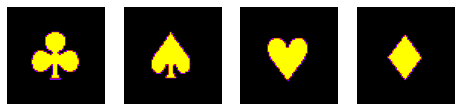

In [ ]:
# Visualizing the cards before applying transformations
fig, ax = plt.subplots(ncols = 4, figsize = (8,2))
for i in range(4):
    ax[i].imshow(cards[i], cmap = 'gnuplot')
    ax[i].axis('off')

# Training
Here we train one model of rVAE per dataset and save the weights.  
These weights will be loaded into the notebook in the next section to avoid the time consuming training process

In [ ]:
# First we initialize the train Loaders for all the datasets

# None corresponds to adding a dummy channel dimension to the dataset
train_loader1 = pv.utils.init_dataloader(cards_all1[:, None], batch_size=50)   #cards-i
train_loader2 = pv.utils.init_dataloader(cards_all2[:, None], batch_size=50)   #cards-ii
train_loader3 = pv.utils.init_dataloader(cards_all3[:, None], batch_size=50)   #cards-iii
train_loader4 = pv.utils.init_dataloader(cards_all4[:, None], batch_size=50)   #cards-iv

In [ ]:
# Training the rVAE on cards-i

in_dim = (48, 48)  # Input dimensions of the dataset i.e., shape of each card's image

# Initialize probabilistic VAE model ->
# (invariances=None: vanilla VAE
#  invariances=['r']: enforces rotational invariance
#  invariances=['t']: enforces translational invariance
#  invariances=['r', 't']: enforces invariance to rotations & translations
#  etc.)


rvae1 = pv.models.iVAE(in_dim, latent_dim=2,  # Number of latent dimensions other than the invariancies
                      hidden_dim_e = [256, 256], # corresponds to the number of neurons in the hidden layers of the encoder
                     hidden_dim_d = [256, 256],  # corresponds to the number of neurons in the hidden layers of the decoder
                     invariances=['r'], seed=0)

# Initialize SVI trainer
trainer1 = pv.trainers.SVItrainer(rvae1)
# Train for n epochs:
for e in range(100):
    trainer1.step(train_loader1)
    trainer1.print_statistics()

# Saving the weights of the trained rVAE model on cards-i
rvae1.save_weights('/content/drive/MyDrive/VAE Review/rvae_files/rave1')

In [ ]:
# Training the rVAE on cards-ii

in_dim = (48, 48)  # Input dimensions of the dataset i.e., shape of each card's image

# Initialize probabilistic VAE model ->
# (invariances=None: vanilla VAE
#  invariances=['r']: enforces rotational invariance
#  invariances=['t']: enforces translational invariance
#  invariances=['r', 't']: enforces invariance to rotations & translations
#  etc.)
rvae2 = pv.models.iVAE(in_dim, latent_dim=2, # Number of latent dimensions other than the invariancies
                      hidden_dim_e = [512, 512],   # corresponds to the number of neurons in the hidden layers of the encoder
                     hidden_dim_d = [512, 512],  # corresponds to the number of neurons in the hidden layers of the decoder
                     invariances=['r'], seed=0)

# Initialize SVI trainer
trainer2 = pv.trainers.SVItrainer(rvae2)
# Train for n epochs:
for e in range(100):
    trainer2.step(train_loader2)
    trainer2.print_statistics()

# Saving the weights of the trained rVAE model on cards-ii
rvae2.save_weights('/content/drive/MyDrive/VAE Review/rvae_files/rave2')


Epoch: 1 Training loss: 646.7454
Epoch: 2 Training loss: 309.6388
Epoch: 3 Training loss: 267.7428
Epoch: 4 Training loss: 227.5838
Epoch: 5 Training loss: 197.7734
Epoch: 6 Training loss: 179.7556
Epoch: 7 Training loss: 166.6508
Epoch: 8 Training loss: 151.2482
Epoch: 9 Training loss: 144.0341
Epoch: 10 Training loss: 139.5901
Epoch: 11 Training loss: 140.0504
Epoch: 12 Training loss: 128.7200
Epoch: 13 Training loss: 130.8168
Epoch: 14 Training loss: 132.7441
Epoch: 15 Training loss: 120.1638
Epoch: 16 Training loss: 122.9823
Epoch: 17 Training loss: 125.5636
Epoch: 18 Training loss: 116.5651
Epoch: 19 Training loss: 123.1803
Epoch: 20 Training loss: 119.3201
Epoch: 21 Training loss: 119.3186
Epoch: 22 Training loss: 115.7934
Epoch: 23 Training loss: 118.5917
Epoch: 24 Training loss: 119.6901
Epoch: 25 Training loss: 117.3284
Epoch: 26 Training loss: 119.0294
Epoch: 27 Training loss: 117.6331
Epoch: 28 Training loss: 114.0104
Epoch: 29 Training loss: 114.1574
Epoch: 30 Training loss

In [ ]:
# Training the rVAE on cards-iii
in_dim = (48, 48)  # Input dimensions of the dataset i.e., shape of each card's image

# Initialize probabilistic VAE model ->
# (invariances=None: vanilla VAE
#  invariances=['r']: enforces rotational invariance
#  invariances=['t']: enforces translational invariance
#  invariances=['r', 't']: enforces invariance to rotations & translations
#  etc.)
rvae3 = pv.models.iVAE(in_dim, latent_dim=2, # Number of latent dimensions other than the invariancies
                      hidden_dim_e = [256, 256],  # corresponds to the number of neurons in the hidden layers of the encoder
                     hidden_dim_d = [256, 256],  # corresponds to the number of neurons in the hidden layers of the decoder
                     invariances=['r'], seed=1)

# Initialize SVI trainer
trainer3 = pv.trainers.SVItrainer(rvae3)
# Train for n epochs:
for e in range(100):
    trainer3.step(train_loader3)
    trainer3.print_statistics()

# Saving the weights of the trained rVAE model on cards-iii
rvae3.save_weights('/content/drive/MyDrive/VAE Review/rvae_files/rave3')

Epoch: 1 Training loss: 604.0801
Epoch: 2 Training loss: 318.4289
Epoch: 3 Training loss: 260.1502
Epoch: 4 Training loss: 226.8224
Epoch: 5 Training loss: 198.1160
Epoch: 6 Training loss: 178.1643
Epoch: 7 Training loss: 157.1614
Epoch: 8 Training loss: 144.8058
Epoch: 9 Training loss: 134.8032
Epoch: 10 Training loss: 126.9972
Epoch: 11 Training loss: 122.0493
Epoch: 12 Training loss: 119.9339
Epoch: 13 Training loss: 117.4189
Epoch: 14 Training loss: 113.9222
Epoch: 15 Training loss: 114.7167
Epoch: 16 Training loss: 110.9354
Epoch: 17 Training loss: 108.7042
Epoch: 18 Training loss: 107.9377
Epoch: 19 Training loss: 106.4181
Epoch: 20 Training loss: 106.3540
Epoch: 21 Training loss: 103.7670
Epoch: 22 Training loss: 103.9035
Epoch: 23 Training loss: 103.1000
Epoch: 24 Training loss: 101.9601
Epoch: 25 Training loss: 100.3479
Epoch: 26 Training loss: 101.1182
Epoch: 27 Training loss: 100.0672
Epoch: 28 Training loss: 99.9653
Epoch: 29 Training loss: 96.1499
Epoch: 30 Training loss: 

In [ ]:
# Training the rVAE on cards-iv

in_dim = (48, 48)  # Input dimensions of the dataset i.e., shape of each card's image

# Initialize probabilistic VAE model ->
# (invariances=None: vanilla VAE
#  invariances=['r']: enforces rotational invariance
#  invariances=['t']: enforces translational invariance
#  invariances=['r', 't']: enforces invariance to rotations & translations
#  etc.)
rvae4 = pv.models.iVAE(in_dim, latent_dim=2,  # Number of latent dimensions other than the invariancies
                      hidden_dim_e = [512, 512],  # corresponds to the number of neurons in the hidden layers of the encoder
                     hidden_dim_d = [512, 512],  # corresponds to the number of neurons in the hidden layers of the decoder
                     invariances=['r'], seed=0)

# Initialize SVI trainer
trainer4 = pv.trainers.SVItrainer(rvae4)
# Train for n epochs:
for e in range(100):
    trainer4.step(train_loader4)
    trainer4.print_statistics()

# Saving the weights of the trained rVAE model on cards-iv
rvae4.save_weights('/content/drive/MyDrive/VAE Review/rvae_files/rave4')

Epoch: 1 Training loss: 684.2742
Epoch: 2 Training loss: 374.7104
Epoch: 3 Training loss: 328.4114
Epoch: 4 Training loss: 288.9217
Epoch: 5 Training loss: 264.4812
Epoch: 6 Training loss: 248.7760
Epoch: 7 Training loss: 230.2745
Epoch: 8 Training loss: 220.6061
Epoch: 9 Training loss: 206.8498
Epoch: 10 Training loss: 195.7785
Epoch: 11 Training loss: 187.7589
Epoch: 12 Training loss: 177.3713
Epoch: 13 Training loss: 175.2696
Epoch: 14 Training loss: 169.4188
Epoch: 15 Training loss: 160.5100
Epoch: 16 Training loss: 161.1411
Epoch: 17 Training loss: 158.3186
Epoch: 18 Training loss: 152.6198
Epoch: 19 Training loss: 159.0636
Epoch: 20 Training loss: 145.9856
Epoch: 21 Training loss: 142.8720
Epoch: 22 Training loss: 148.5931
Epoch: 23 Training loss: 149.6778
Epoch: 24 Training loss: 145.2412
Epoch: 25 Training loss: 147.1301
Epoch: 26 Training loss: 143.7685
Epoch: 27 Training loss: 143.9408
Epoch: 28 Training loss: 141.9064
Epoch: 29 Training loss: 140.8644
Epoch: 30 Training loss

# Visulizing the results
Saved weights will be downloaded in the corresponding sections

## cards-i 
Low rotation (12 deg) and low shear (1 deg)

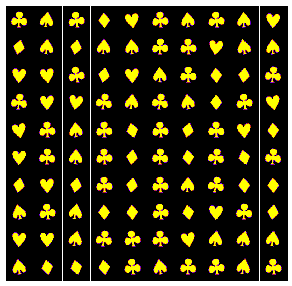

In [ ]:
# First let's just visualize some randomly picked samples from the input dataset

np.random.seed(1)  # fix seed so that we get the same samples displayed at every run
fig, axes = plt.subplots(10, 10, figsize=(5, 5),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(cards_all1))
    ax.imshow(cards_all1[i], cmap='gnuplot', interpolation='nearest')

In [ ]:
# Initializing a new network
rvae1 = pv.models.iVAE((48, 48), latent_dim=2,
                      hidden_dim_e = [256,256],
                     hidden_dim_d = [256,256],
                     invariances=['r'], seed=0)

# Download the weigths file 
!gdown 1xTiHFNo6IU0wkovEsIznKbmna3vgAHdI

# Loading the saved weights into the newly initialized network
rvae1.load_weights('rvae1.pt')

Downloading...
From: https://drive.google.com/uc?id=1xTiHFNo6IU0wkovEsIznKbmna3vgAHdI
To: /content/rave1.pt
100% 3.17M/3.17M [00:00<00:00, 208MB/s]


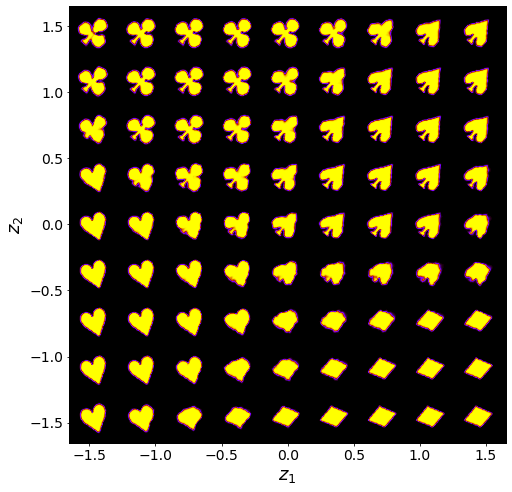

tensor([[[1.1468e-09, 2.8326e-09, 5.5827e-09,  ..., 5.0601e-14,
          2.4689e-14, 1.0278e-14],
         [6.0838e-10, 1.7792e-09, 4.3682e-09,  ..., 2.8518e-14,
          1.0310e-14, 3.2649e-15],
         [2.8303e-10, 9.5444e-10, 2.8350e-09,  ..., 1.1542e-14,
          3.3791e-15, 1.4093e-15],
         ...,
         [1.0017e-10, 9.9368e-11, 1.5708e-10,  ..., 1.7478e-10,
          8.8669e-11, 4.5499e-11],
         [7.4009e-11, 1.0632e-10, 2.6144e-10,  ..., 1.6659e-10,
          9.2288e-11, 4.8458e-11],
         [7.6181e-11, 1.6367e-10, 3.7144e-10,  ..., 1.3759e-10,
          8.7844e-11, 4.9848e-11]],

        [[1.5518e-09, 3.0411e-09, 4.5469e-09,  ..., 7.5811e-14,
          2.2678e-14, 4.7467e-15],
         [1.0184e-09, 2.2909e-09, 4.1141e-09,  ..., 2.3555e-14,
          4.4833e-15, 1.1043e-15],
         [6.2340e-10, 1.6172e-09, 3.3377e-09,  ..., 4.5001e-15,
          1.1795e-15, 8.6256e-16],
         ...,
         [1.2733e-10, 1.0180e-10, 1.2020e-10,  ..., 1.8147e-11,
          1.132

In [ ]:
# Decoded latent space:
# The latent space is uniformly sampled in z1-z2 latent dimensions. 
# These points are decoded back into the image space and are plotted in their corresponding latent space positions


rvae1.manifold2d(d = 9)   # d corresponds to the number of points sampled in each latent dimension

Latent Distributions:  
Input images are represented as points in the latent space using the encoder  
These points are then colored with various ground-truth properties to visualize their distribution 

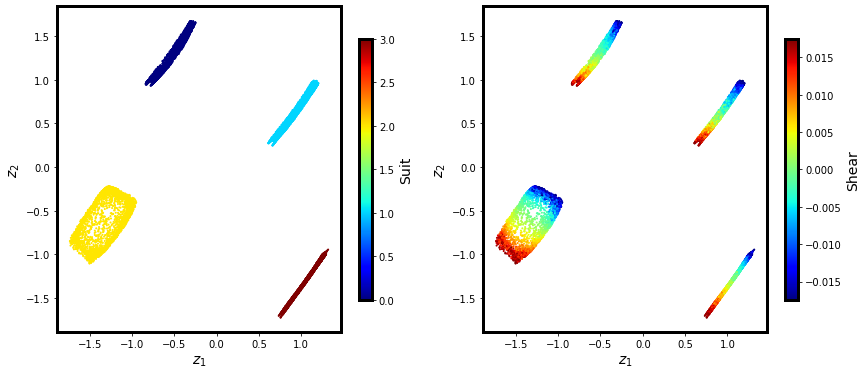

In [ ]:
z_mean1, z_sd1 = rvae1.encode(cards_all1)   # Encoding the full input dataset
# z_mean1: mean of the latent space representation of the input dataset, 
# z_sd1: standard deviation of the latent space representation of the input dataset,
# 0th column corresponds to angle and then the regular latent dimensions (First invariant dimensions and then regular latent dimensions) 


# Latent distribution colored using the suit of each image
fig, ax = plt.subplots(1, 2, figsize =(14, 6))
im = ax[0].scatter(z_mean1[:,-1], z_mean1[:,-2], c=labels_all1, s=1, cmap='jet')
ax[0].set_xlabel("$z_1$", fontsize=14)
ax[0].set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax[0], shrink=.8)
cbar.set_label("Suit", fontsize=14)
cbar.ax.tick_params(labelsize=10)

# Latent distribution colored using the ground truth shear applied on each image
im = ax[1].scatter(z_mean1[:,-1], z_mean1[:,-2], c=shears_all1[:,0], s=1, cmap='jet')
ax[1].set_xlabel("$z_1$", fontsize=14)
ax[1].set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax[1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)


plt.show()

Text(0, 0.5, 'angular encoding')

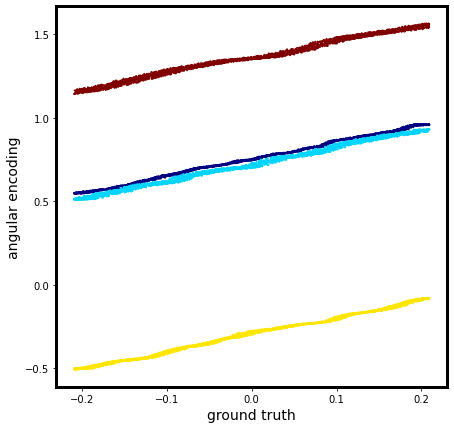

In [ ]:
# Finally the plot of encoded angle vs. ground truth rotation applied to the images. 
# The points are colored using the suit of the images.

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(torch.deg2rad(angles_all1), z_mean1[:,0], c = labels_all1, s =1, cmap = 'jet')
ax.set_xlabel("ground truth", fontsize=14)
ax.set_ylabel("angular encoding", fontsize=14)


## cards-ii 
Low rotation (12 deg) High shear (20deg)

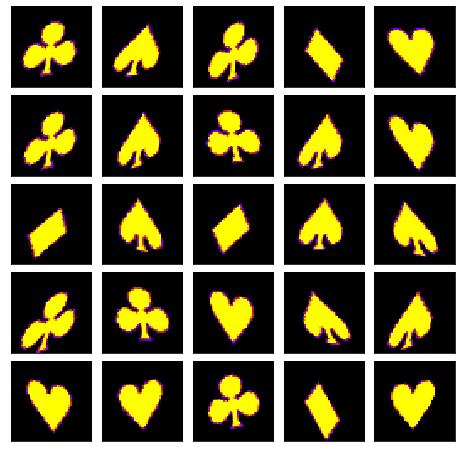

In [ ]:
# First let's just visualize some randomly picked samples from the input dataset

np.random.seed(1)  # fix seed so that we get the same samples displayed at every run
fig, axes = plt.subplots(5, 5, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(cards_all2))
    ax.imshow(cards_all2[i], cmap='gnuplot', interpolation='nearest')

In [ ]:
# Initializing a new network
rvae2 = pv.models.iVAE((48, 48), latent_dim=2, 
                      hidden_dim_e = [512,512],
                     hidden_dim_d = [512,512],
                     invariances=['r'], seed=0)

# Download the weigths file 
!gdown 1-1xnfzcKQuZ1qJJbkiuz6nglwIpZXSx8

# Loading the saved weights into the newly initialized network
rvae2.load_weights('rvae2.pt')

Downloading...
From: https://drive.google.com/uc?id=1-1xnfzcKQuZ1qJJbkiuz6nglwIpZXSx8
To: /content/rave2.pt
100% 7.90M/7.90M [00:00<00:00, 21.1MB/s]


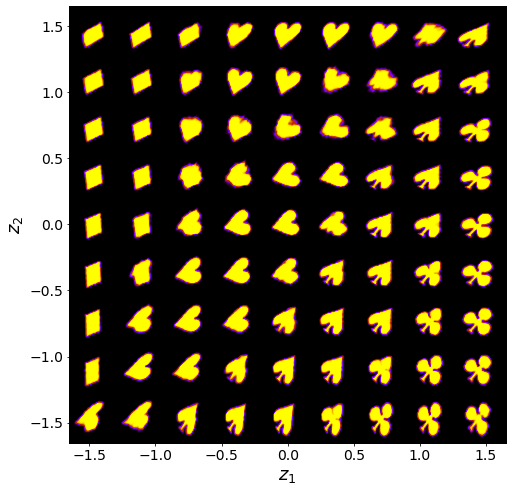

tensor([[[3.9037e-14, 6.0535e-14, 8.7713e-14,  ..., 9.4729e-15,
          9.4860e-15, 9.2481e-15],
         [5.6135e-14, 7.1412e-14, 9.2486e-14,  ..., 9.0920e-15,
          8.9081e-15, 8.4188e-15],
         [1.1814e-13, 1.1932e-13, 1.2627e-13,  ..., 9.4188e-15,
          8.9379e-15, 8.5208e-15],
         ...,
         [1.8177e-12, 2.4347e-12, 5.7659e-12,  ..., 7.6780e-14,
          4.1996e-14, 2.9992e-14],
         [1.1259e-12, 2.5575e-12, 5.3991e-12,  ..., 1.3707e-13,
          7.4020e-14, 4.6033e-14],
         [1.1256e-12, 2.2667e-12, 3.6075e-12,  ..., 2.0622e-13,
          1.3570e-13, 7.3620e-14]],

        [[9.4906e-15, 1.4104e-14, 2.4267e-14,  ..., 4.8643e-15,
          3.5226e-15, 2.9307e-15],
         [1.0062e-14, 1.2169e-14, 1.8165e-14,  ..., 4.1549e-15,
          3.2327e-15, 2.8578e-15],
         [1.3199e-14, 1.4179e-14, 1.7181e-14,  ..., 3.6432e-15,
          3.1770e-15, 2.8623e-15],
         ...,
         [1.6161e-12, 1.5064e-12, 1.6120e-12,  ..., 7.6933e-14,
          5.803

In [ ]:
# Decoded latent space:
# The latent space is uniformly sampled in z1-z2 latent dimensions. 
# These points are decoded back into the image space and are plotted in their corresponding latent space positions

rvae2.manifold2d(d = 9)  # d corresponds to the number of points sampled in each latent dimension

Latent Distributions:  
Input images are represented as points in the latent space using the encoder  
These points are then colored with various ground-truth properties to visualize their distribution 

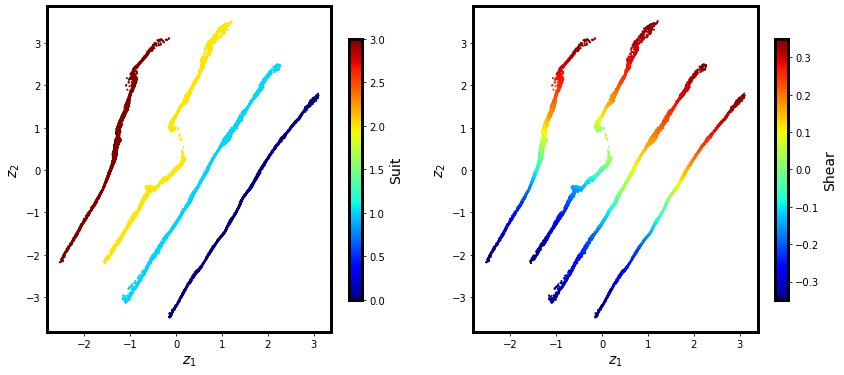

In [ ]:
z_mean2, z_sd2 = rvae2.encode(cards_all2)  # Encoding the full input dataset
# z_mean2: mean of the latent space representation of the input dataset, 
# z_sd2: standard deviation of the latent space representation of the input dataset,
# 0th column corresponds to angle and then the regular latent dimensions (First invariant dimensions and then regular latent dimensions) 


# Latent distribution colored using the suit of each image
fig, ax = plt.subplots(1, 2, figsize =(14, 6))
im = ax[0].scatter(z_mean2[:,-1], z_mean2[:,-2], c=labels_all2, s=1, cmap='jet')
ax[0].set_xlabel("$z_1$", fontsize=14)
ax[0].set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax[0], shrink=.8)
cbar.set_label("Suit", fontsize=14)
cbar.ax.tick_params(labelsize=10)

# Latent distribution colored using the ground-truth shear of each image
im = ax[1].scatter(z_mean2[:,-1], z_mean2[:,-2], c=shears_all2[:,0], s=1, cmap='jet')
ax[1].set_xlabel("$z_1$", fontsize=14)
ax[1].set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax[1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)
plt.show()

Text(0, 0.5, 'angular encoding')

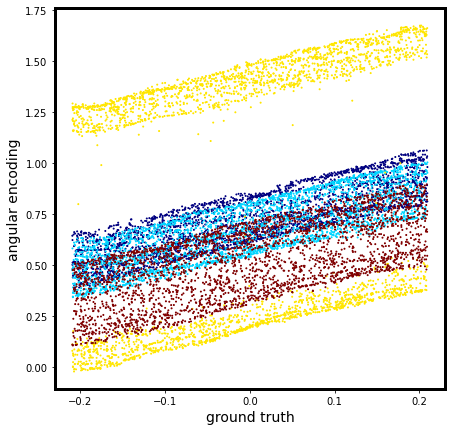

In [ ]:
# Finally the plot of encoded angle vs. ground truth rotation applied to the images. 
# The points are colored using the suit of the images.

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(torch.deg2rad(angles_all2), z_mean2[:,0], c = labels_all2, s =1, cmap = 'jet')
ax.set_xlabel("ground truth", fontsize=14)
ax.set_ylabel("angular encoding", fontsize=14)

## cards-iii 
High rotation (120 degrees) and Low shear (1 degree)

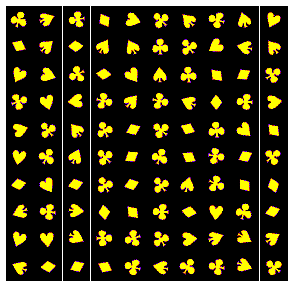

In [ ]:
# First let's just visualize some randomly picked samples from the input dataset

np.random.seed(1)  # fix seed so that we get the same samples displayed at every run
fig, axes = plt.subplots(10, 10, figsize=(5, 5),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(cards_all3))
    ax.imshow(cards_all3[i], cmap='gnuplot', interpolation='nearest')

In [ ]:
# Initializing a new network
rvae3 = pv.models.iVAE((48, 48), latent_dim=2,
                      hidden_dim_e = [256,256],
                     hidden_dim_d = [256,256],
                     invariances=['r'], seed=0)

# Download the weigths file 
!gdown 1-2RLvpje9EVphg4o5ybKXlN3WVqCQdhT

# Loading the saved weights into the newly initialized network
rvae3.load_weights('rvae3.pt')

Downloading...
From: https://drive.google.com/uc?id=1-2RLvpje9EVphg4o5ybKXlN3WVqCQdhT
To: /content/rave3.pt
100% 3.17M/3.17M [00:00<00:00, 197MB/s]


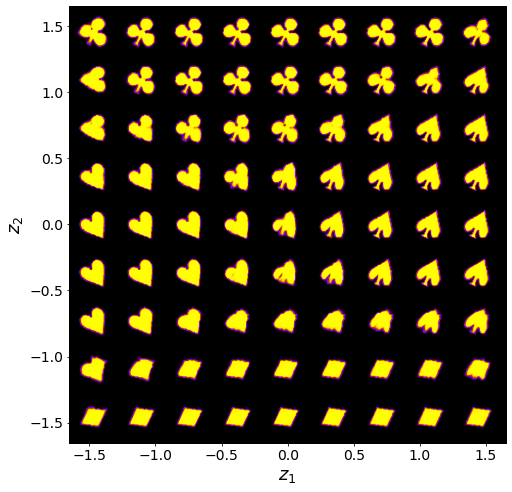

tensor([[[1.4053e-14, 1.3226e-14, 1.5620e-14,  ..., 2.0938e-13,
          1.5425e-13, 1.0883e-13],
         [2.7584e-14, 1.9949e-14, 1.8625e-14,  ..., 2.3502e-13,
          1.5839e-13, 1.0664e-13],
         [7.1736e-14, 4.1993e-14, 3.0056e-14,  ..., 2.6221e-13,
          1.6904e-13, 1.0920e-13],
         ...,
         [1.0634e-10, 3.2817e-10, 9.8305e-10,  ..., 1.1104e-09,
          8.8409e-10, 5.4440e-10],
         [1.8410e-10, 4.4601e-10, 1.1133e-09,  ..., 6.3847e-10,
          7.2802e-10, 6.8155e-10],
         [2.0606e-10, 4.3053e-10, 9.2573e-10,  ..., 2.2664e-10,
          3.2803e-10, 4.3887e-10]],

        [[3.2787e-14, 9.4262e-15, 5.8202e-15,  ..., 1.9432e-13,
          1.5017e-13, 1.1885e-13],
         [2.0210e-13, 3.6907e-14, 1.0634e-14,  ..., 2.1148e-13,
          1.6278e-13, 1.2471e-13],
         [9.8967e-13, 2.3688e-13, 4.3908e-14,  ..., 2.5645e-13,
          1.9441e-13, 1.3780e-13],
         ...,
         [9.5462e-12, 4.0587e-11, 1.6344e-10,  ..., 3.8553e-09,
          2.761

In [ ]:
# Decoded latent space:
# The latent space is uniformly sampled in z1-z2 latent dimensions. 
# These points are decoded back into the image space and are plotted in their corresponding latent space positions

rvae3.manifold2d(d = 9)   # d corresponds to the number of points sampled in each latent dimension

Latent Distributions:  
Input images are represented as points in the latent space using the encoder  
These points are then colored with various ground-truth properties to visualize their distribution 

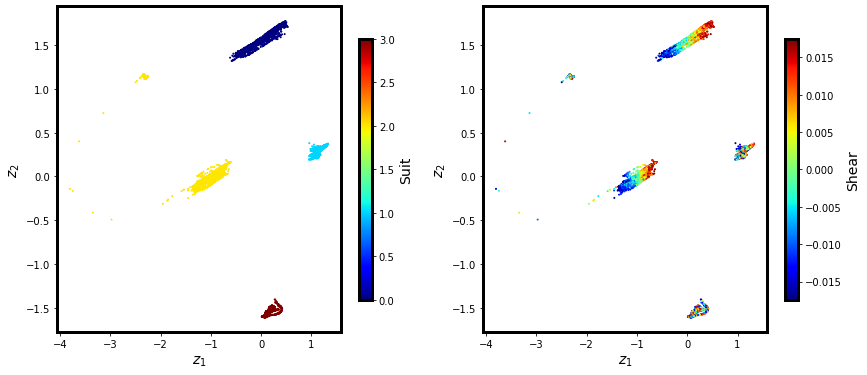

In [ ]:
z_mean3, z_sd3 = rvae3.encode(cards_all3)   # Encoding the full input dataset
# z_mean3: mean of the latent space representation of the input dataset, 
# z_sd3: standard deviation of the latent space representation of the input dataset,
# 0th column corresponds to angle and then the regular latent dimensions (First invariant dimensions and then regular latent dimensions) 


# Latent distribution colored using the suit of each image
fig, ax = plt.subplots(1, 2, figsize =(14, 6))
im = ax[0].scatter(z_mean3[:,-1], z_mean3[:,-2], c=labels_all3, s=1, cmap='jet')
ax[0].set_xlabel("$z_1$", fontsize=14)
ax[0].set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax[0], shrink=.8)
cbar.set_label("Suit", fontsize=14)
cbar.ax.tick_params(labelsize=10)

# Latent distribution colored using the ground-truth shear of each image
im = ax[1].scatter(z_mean3[:,-1], z_mean3[:,-2], c=shears_all3[:,0], s=1, cmap='jet')
ax[1].set_xlabel("$z_1$", fontsize=14)
ax[1].set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax[1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

plt.show()

Text(0, 0.5, 'angular encoding')

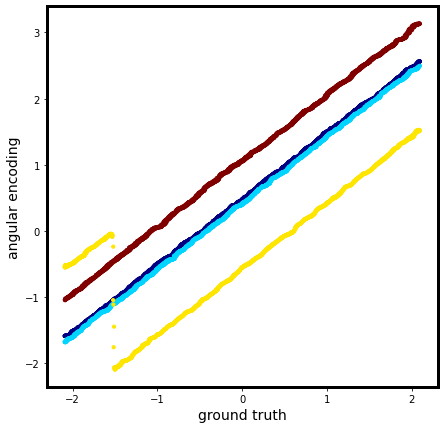

In [ ]:
# Finally the plot of encoded angle vs. ground truth rotation applied to the images. 
# The points are colored using the suit of the images.

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(torch.deg2rad(angles_all3), z_mean3[:,0], c = labels_all3, s =10, cmap = 'jet')
ax.set_xlabel("ground truth", fontsize=14)
ax.set_ylabel("angular encoding", fontsize=14)


## cards-iv 
High rotation (120 degrees) and high shear (20 degrees)

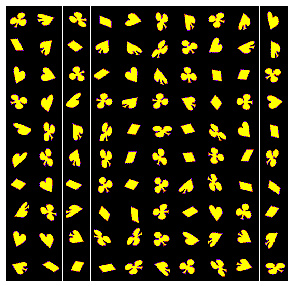

In [ ]:
# First let's just visualize some randomly picked samples from the input dataset

np.random.seed(1)  # fix seed so that we get the same samples displayed at every run
fig, axes = plt.subplots(10, 10, figsize=(5, 5),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(cards_all4))
    ax.imshow(cards_all4[i], cmap='gnuplot', interpolation='nearest')

In [ ]:
# Initializing a new network
rvae4 = pv.models.iVAE((48, 48), latent_dim=2, 
                      hidden_dim_e = [512,512],
                     hidden_dim_d = [512,512],
                     invariances=['r'], seed=0)

# Download the weigths file 
!gdown 1-7z8pdIf5cpIUxF6SestucWURbhww_Ta

# Loading the saved weights into the newly initialized network
rvae4.load_weights('rvae4.pt')

Downloading...
From: https://drive.google.com/uc?id=1-7z8pdIf5cpIUxF6SestucWURbhww_Ta
To: /content/rave4.pt
100% 7.90M/7.90M [00:00<00:00, 122MB/s]


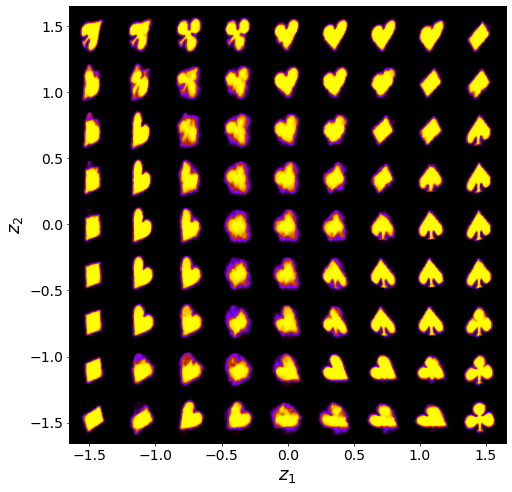

tensor([[[3.8292e-09, 6.4712e-09, 7.0848e-09,  ..., 6.2728e-13,
          8.4270e-13, 1.1977e-12],
         [2.7077e-09, 6.5434e-09, 1.0518e-08,  ..., 9.6054e-13,
          1.2969e-12, 1.7241e-12],
         [1.5391e-09, 4.6744e-09, 1.0148e-08,  ..., 1.4152e-12,
          1.8170e-12, 2.3383e-12],
         ...,
         [2.2823e-09, 7.3273e-09, 2.8955e-08,  ..., 2.5266e-08,
          2.1827e-08, 1.6112e-08],
         [3.6312e-09, 1.2123e-08, 4.2722e-08,  ..., 1.6703e-08,
          1.7139e-08, 1.5166e-08],
         [4.1294e-09, 1.4240e-08, 4.3518e-08,  ..., 1.1648e-08,
          1.2697e-08, 1.3497e-08]],

        [[1.0983e-08, 1.4027e-08, 1.0273e-08,  ..., 4.2127e-12,
          2.4834e-12, 2.1887e-12],
         [1.2484e-08, 2.2166e-08, 2.1828e-08,  ..., 2.6012e-12,
          2.0702e-12, 2.1231e-12],
         [1.0056e-08, 3.0034e-08, 4.0458e-08,  ..., 1.9981e-12,
          1.9921e-12, 2.2609e-12],
         ...,
         [1.1325e-09, 3.7605e-09, 1.4414e-08,  ..., 1.6955e-07,
          1.170

In [ ]:
# Decoded latent space:
# The latent space is uniformly sampled in z1-z2 latent dimensions. 
# These points are decoded back into the image space and are plotted in their corresponding latent space positions

rvae4.manifold2d(d = 9)   # d corresponds to the number of points sampled in each latent dimension

Latent Distributions:  
Input images are represented as points in the latent space using the encoder  
These points are then colored with various ground-truth properties to visualize their distribution 

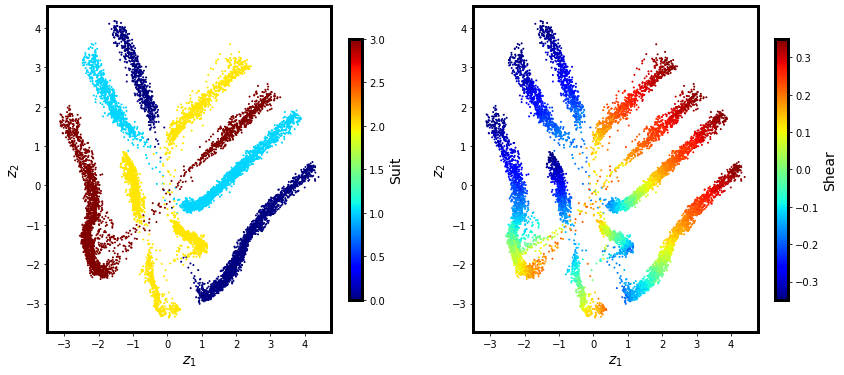

In [ ]:
z_mean4, z_sd4 = rvae4.encode(cards_all4[:, None])  # Encoding the full input dataset
# z_mean4: mean of the latent space representation of the input dataset, 
# z_sd4: standard deviation of the latent space representation of the input dataset,
# 0th column corresponds to angle and then the regular latent dimensions (First invariant dimensions and then regular latent dimensions) 


# Latent distribution colored using the suit of each image
fig, ax = plt.subplots(1, 2, figsize =(14, 6))
im = ax[0].scatter(z_mean4[:,-1], z_mean4[:,-2], c=labels_all4, s=1, cmap='jet')
ax[0].set_xlabel("$z_1$", fontsize=14)
ax[0].set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax[0], shrink=.8)
cbar.set_label("Suit", fontsize=14)
cbar.ax.tick_params(labelsize=10)


# Latent distribution colored using the ground truth shear of each image
im = ax[1].scatter(z_mean4[:,-1], z_mean4[:,-2], c=shears_all4[:,0], s=1, cmap='jet')
ax[1].set_xlabel("$z_1$", fontsize=14)
ax[1].set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax[1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

plt.show()

Text(0, 0.5, 'angular encoding')

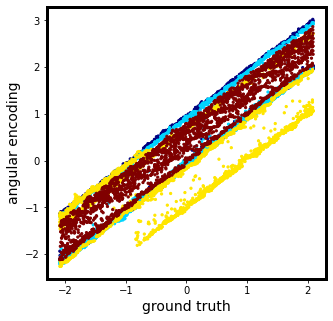

In [ ]:
# Finally the plot of encoded angle vs. ground truth rotation applied to the images. 
# The points are colored using the suit of the images.

fig, ax = plt.subplots(figsize = (5,5), linewidth = 500)
ax.scatter(torch.deg2rad(angles_all4), z_mean4[:,0], c = labels_all4, s =5, cmap = 'jet')
ax.set_xlabel("ground truth", fontsize=14)
ax.set_ylabel("angular encoding", fontsize=14)